In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import cv2 as cv
from PIL import Image
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#Face Segmentation

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.1 MB/s eta 0:00:00


In [ ]:
base_dir = '/content/drive/MyDrive/Uwe'

In [ ]:
original_dir = os.path.join(base_dir, 'Season_Revisi')
season_list = ['Autumn', 'Spring', 'Summer', 'Winter']

In [ ]:
season_dir = [os.path.join(original_dir, season) for season in season_list]

In [ ]:
file_path = []
file_extension = ['.jpg', '.jpeg', '.png']

for season in season_dir:
  for file_name in os.listdir(season):
    if not any(ext in file_name for ext in file_extension):
      continue
    file_path.append(os.path.join(season, file_name))

In [ ]:
print(len(file_path))

1108


In [ ]:
def showImages(image_list, length=10):
    rows = length // 5
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

    for i in range(length):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(image_list[i])
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.show()

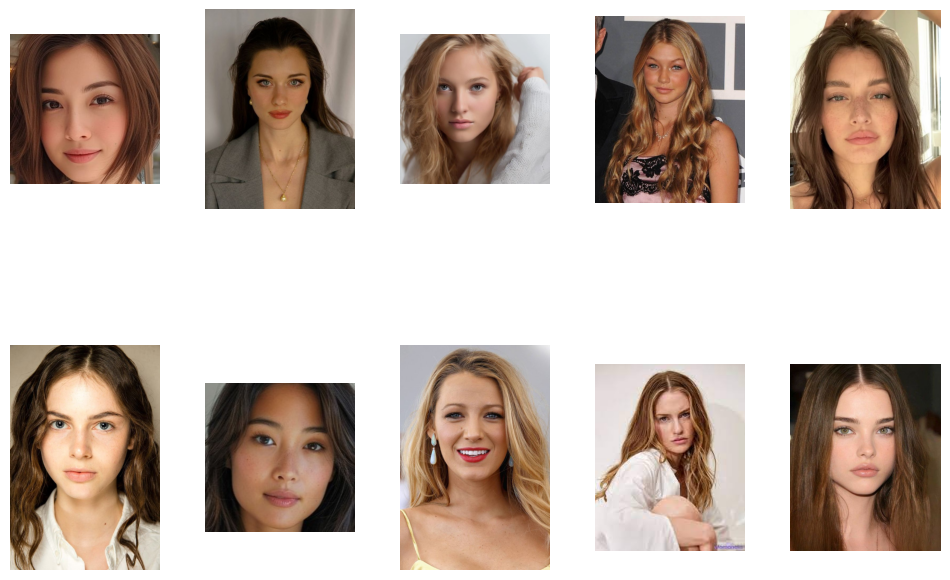

In [ ]:
image_list = []
sample_dir = '/content/drive/MyDrive/Uwe/Season_Revisi/Autumn'
sample_file = os.listdir(sample_dir)[:10]

for file_name in sample_path:
    img_path = os.path.join(sample_dir, file_name)
    img = cv.imread(img_path)
    if img is not None:
        image_list.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))

showImages(image_list)

In [ ]:
def make_square(bbox, padding=0):
    x, y, width, height = bbox
    if width != height:
        max_side = max(width, height)
        x_center = x + width // 2
        y_center = y + height // 2
        x = x_center - max_side // 2
        y = y_center - max_side // 2

        # Memastikan x dan y tidak negatif
        x = max(0, x_center - max_side // 2)
        y = max(0, y_center - max_side // 2)

        width = height = max_side

    x -= padding
    y -= padding
    width += 2 * padding
    height += 2 * padding

    x = max(0, x)
    y = max(0, y)

    return x, y, width, height

In [ ]:
def save_image_to_jpg(image, file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    cv.imwrite(file_path, image_rgb, [int(cv.IMWRITE_JPEG_QUALITY), 90])

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()

for index, image_path in enumerate(file_path):
    print(image_path)
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    result = detector.detect_faces(image)
    x, y, width, height = make_square(result[0]['box'])
    segmented_image = image[y:y+height, x:x+width]

    path_list = image_path.split(os.sep)
    # Transfer the file to a new directory
    path_list[5] = 'Season_Revisi_Segmented'
    new_path = os.sep.join(path_list)
    print(new_path)

    save_image_to_jpg(segmented_image, new_path)

    print(f'{index+1}/{len(file_path)}')

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Winter/summer 80.jpeg
801/1108
/content/drive/MyDrive/Uwe/Season_Revisi/Winter/winter_284.jpg
1/1 [==============================] - 0s 48ms/step
/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Winter/winter_284.jpg
802/1108
/content/drive/MyDrive/Uwe/Season_Revisi/Winter/winter_273.jpg
1/1 [==============================] - 0s 69ms/step
/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Winter/winter_273.jpg
803/1108
/content/drive/MyDrive/Uwe/Season_Revisi/Winter/winter_281.jpg
1/1 [==============================] - 0s 36ms/step
/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Winter/winter_281.jpg
804/1108
/content/drive/MyDrive/Uwe/Season_Revisi/Winter/winter_312.jpeg
1/1 [==============================] - 0s 26ms/step
/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Winter/winter_312.jpeg
805/1108
/content/drive/MyDrive/Uwe/Season_Revisi/Winter/winter_283.jpg
1/1 [=========

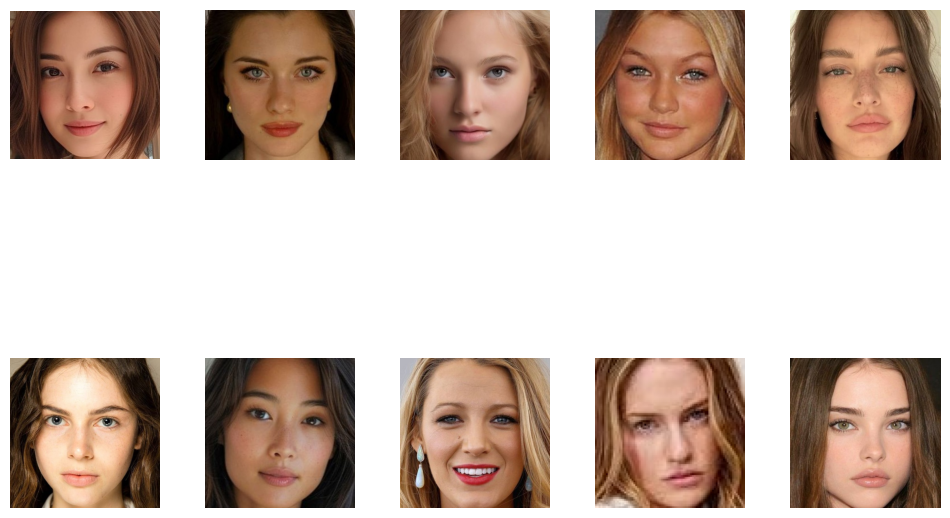

In [ ]:
image_list = []
sample_dir = '/content/drive/MyDrive/Uwe/Season_Revisi_Segmented/Autumn'
sample_file = os.listdir(sample_dir)[:10]

for file_name in sample_path:
    img_path = os.path.join(sample_dir, file_name)
    img = cv.imread(img_path)
    if img is not None:
        image_list.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))

showImages(image_list)

In [ ]:
from mtcnn.mtcnn import MTCNN

result = []

detector = MTCNN()
for i in range(len(image_list)):
  result.append(detector.detect_faces(image_list[i]))
  print(f'{i+1}/{len(image_list)} image done!')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
747/1103 image done!
1/1 [==============================] - 0s 19ms/step
748/1103 image done!
1/1 [==============================] - 0s 37ms/step
749/1103 image done!
1/1 [==============================] - 0s 30ms/step
750/1103 image done!
1/1 [==============================] - 0s 52ms/step
751/1103 image done!
1/1 [==============================] - 0s 19ms/step
752/1103 image done!
1/1 [==============================] - 0s 18ms/step
753/1103 image done!
1/1 [==============================] - 0s 18ms/step
754/1103 image done!
1/1 [==============================] - 0s 18ms/step
755/1103 image done!
1/1 [==============================] - 0s 18ms/step
756/1103 image done!
1/1 [==============================] - 0s 17ms/step
757/1103 image done!
1/1 [==============================] - 0s 17ms/step
758/1103 image done!
1/1 [==============================] - 0s 43ms/step
759/1103 image done!


In [ ]:
def make_square(bbox):
  x, y, width, height = bbox
  if width != height:
    max_side = max(width, height)
    x_center = x + width // 2
    y_center = y + height // 2
    x = x_center - max_side // 2
    y = y_center - max_side // 2

    # Memastikan x dan y tidak negatif
    x = max(0, x_center - max_side // 2)
    y = max(0, y_center - max_side // 2)

    width = height = max_side
  return x, y, width, height

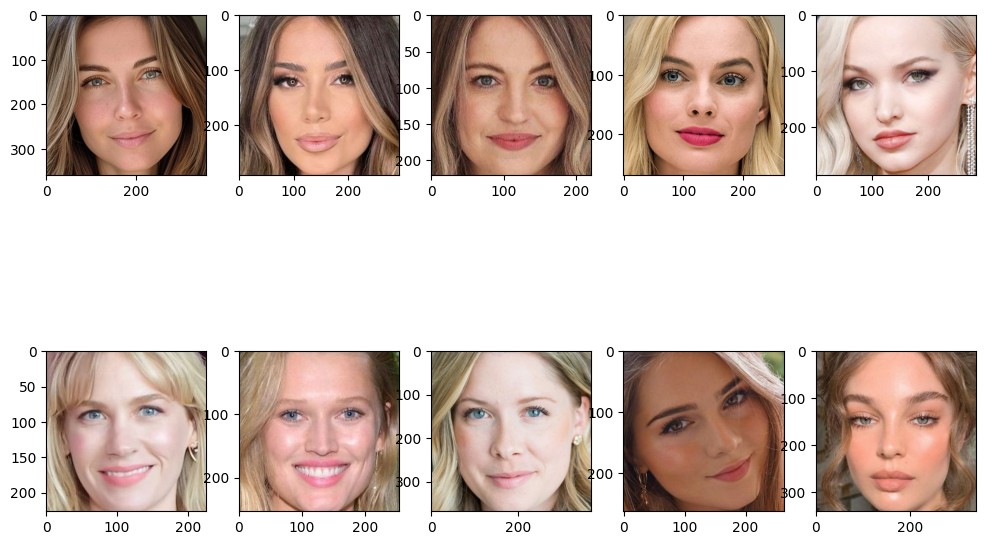

In [ ]:
image_list_segmented = []

for i in range(len(image_list)):
  x, y, width, height = make_square(result[i][0]['box'])
  image_segmented = image_list[i][y:y+height, x:x+width]
  image_list_segmented.append(image_segmented)

showImages(image_list_segmented)

In [ ]:
segmented_dir = '/content/drive/MyDrive/Uwe/Season_Revisi_Segmented'
for season in season_list:
  print(f'{season} image results count: {len(os.listdir(os.path.join(segmented_dir, season)))}')

Autumn image results count: 264
Spring image results count: 77
Summer image results count: 307
Winter image results count: 448


## Rename files

Optional, if you want to standardized the file names

In [ ]:
for season in season_path:
  season_file_list = os.listdir(season)
  for i in range(len(season_file_list)):
    old_file_path = os.path.join(season, season_file_list[i])
    new_file_path = os.path.join(season, f'{season}{i+1}.jpg')
    print(old_file_path)
    print(new_file_path)

    # os.rename(old_file_path, new_file_path)

print(season_path)

['/content/drive/MyDrive/Capstone/SeasonSegmented/Summer', '/content/drive/MyDrive/Capstone/SeasonSegmented/Autumn', '/content/drive/MyDrive/Capstone/SeasonSegmented/Spring', '/content/drive/MyDrive/Capstone/SeasonSegmented/Winter']


#Training

##Imports and Setup

In [266]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

from sklearn.metrics import confusion_matrix

## Preprocessing

In [267]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = '/content/drive/MyDrive/Uwe/Season_Revisi_Segmented_Added'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 1250 files belonging to 4 classes.
Using 1000 files for training.
Found 1250 files belonging to 4 classes.
Using 250 files for validation.


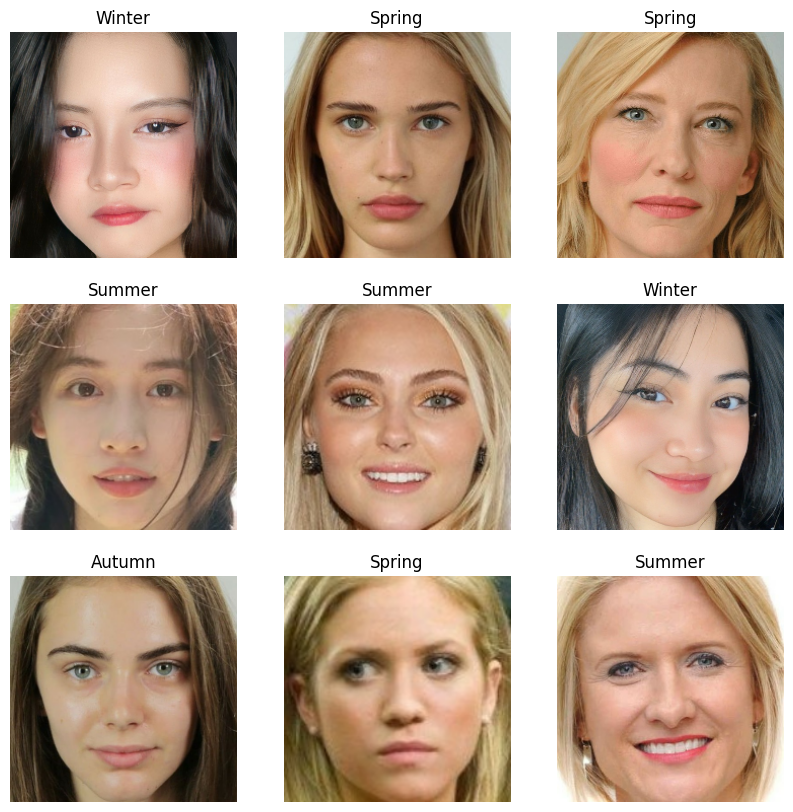

In [268]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Augmentation

In [269]:
def color_jitter(image, brightness=0.005, contrast=0.005, saturation=0.005, hue=0.005):
    """
    Apply random brightness, contrast, saturation, and hue adjustments to an image.

    Args:
        image (tf.Tensor): Input image.
        brightness (float): Brightness adjustment factor.
        contrast (float): Contrast adjustment factor.
        saturation (float): Saturation adjustment factor.
        hue (float): Hue adjustment factor.

    Returns:
        tf.Tensor: Augmented image.
    """
    image = tf.image.random_brightness(image, max_delta=brightness)
    image = tf.image.random_contrast(image, lower=1-contrast, upper=1+contrast)
    image = tf.image.random_saturation(image, lower=1-saturation, upper=1+saturation)
    image = tf.image.random_hue(image, max_delta=hue)

    return image

In [270]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.Rescaling(scale=1/255.)
])

In [271]:
# # Apply data augmentation to the training dataset
# augmented_train_dataset = train_dataset.map(
#     lambda x, y: (data_augmentation(x, training=True), y),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# # Prefetch the datasets for performance optimization
# augmented_train_dataset = augmented_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [272]:
# def augment_underrepresented_class(train_ds, underrepresented_label, augmentation_pipeline, repeat_count):
#     class_data = []
#     class_labels = []

#     # Separate underrepresented class
#     for images, labels in train_ds.unbatch():
#         if labels.numpy() == underrepresented_label:
#             for _ in range(repeat_count):
#                 augmented_image = augmentation_pipeline(tf.expand_dims(images, 0))
#                 class_data.append(augmented_image[0])
#                 class_labels.append(labels)

#     # Convert to TensorFlow dataset
#     class_data = tf.data.Dataset.from_tensor_slices((class_data, class_labels))

#     # Apply data augmentation
#     augmented_class_data = class_data.map(
#         lambda x, y: (augmentation_pipeline(x, training=True), y),
#         num_parallel_calls=tf.data.AUTOTUNE
#     ).repeat(repeat_count)

#     return augmented_class_data

# # Define the underrepresented label
# underrepresented_label = 1  # Replace with your specific label

# # Augment the underrepresented class dataset
# augmented_underrepresented_class_dataset = augment_underrepresented_class(
#     train_dataset,
#     underrepresented_label,
#     data_augmentation,
#     repeat_count=180  # Number of times to repeat augmentation
# )

# # Combine the original training dataset with the augmented underrepresented class dataset
# combined_train_dataset = augmented_train_dataset.concatenate(augmented_underrepresented_class_dataset)

# # Shuffle and batch the combined dataset
# combined_train_dataset = combined_train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# # Validation dataset remains unchanged
# validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


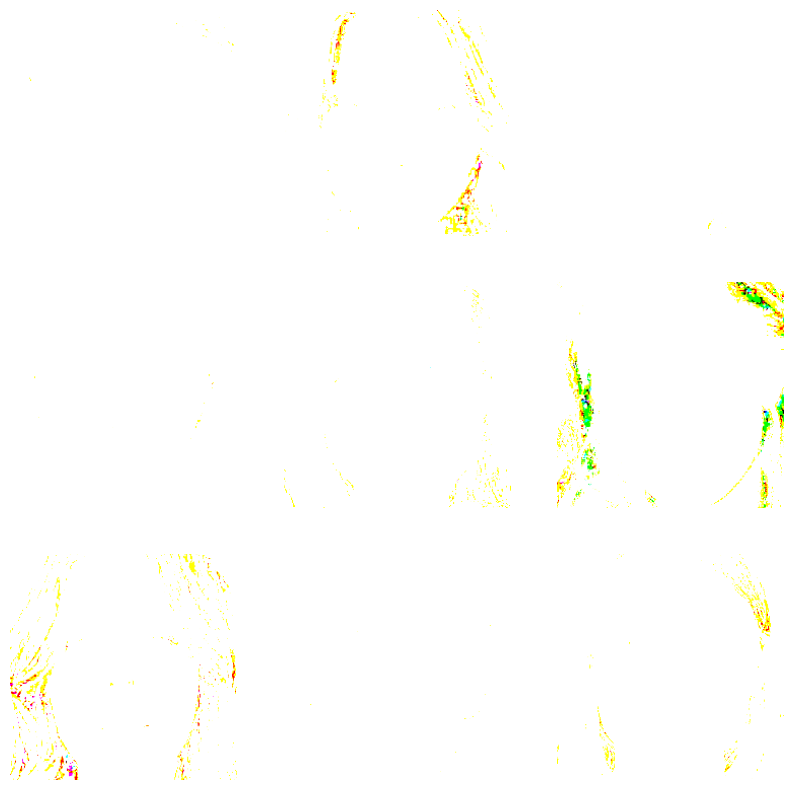

In [273]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.axis('off')

In [274]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [275]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


##Feature Extraction

In [276]:
# Freeze weights for now
base_model.trainable = False

In [277]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_20[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [278]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [279]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [280]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [281]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [282]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.

Check the trainable variables (should be a small number)

In [283]:
len(model.trainable_variables)

2

In [284]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=3,
)

In [285]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Uwe/best_model_seasonal-added.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [286]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [287]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[
                        reduce_lr,
                        checkpoint_callback,
                        early_stopping,
                    ])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.3723 - accuracy: 0.3620
Epoch 1: val_accuracy improved from -inf to 0.44400, saving model to /content/drive/MyDrive/Uwe/best_model_seasonal-added.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 14s 317ms/step - loss: 1.3723 - accuracy: 0.3620 - val_loss: 1.2798 - val_accuracy: 0.4440 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.2848 - accuracy: 0.4260
Epoch 2: val_accuracy improved from 0.44400 to 0.48000, saving model to /content/drive/MyDrive/Uwe/best_model_seasonal-added.h5
32/32 [==============================] - 10s 293ms/step - loss: 1.2848 - accuracy: 0.4260 - val_loss: 1.2438 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 3/50
31/32 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.4405
Epoch 3: val_accuracy improved from 0.48000 to 0.48800, saving model to /content/drive/MyDrive/Uwe/best_model_seasonal-added.h5
32/32 [==============================] - 9s 267ms/step - loss: 1.2300 - accuracy: 0.4410 - val_loss: 1.2135 - val_accuracy: 0.4880 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.4850
Epoch 4: val_acc

##Evaluation

In [288]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

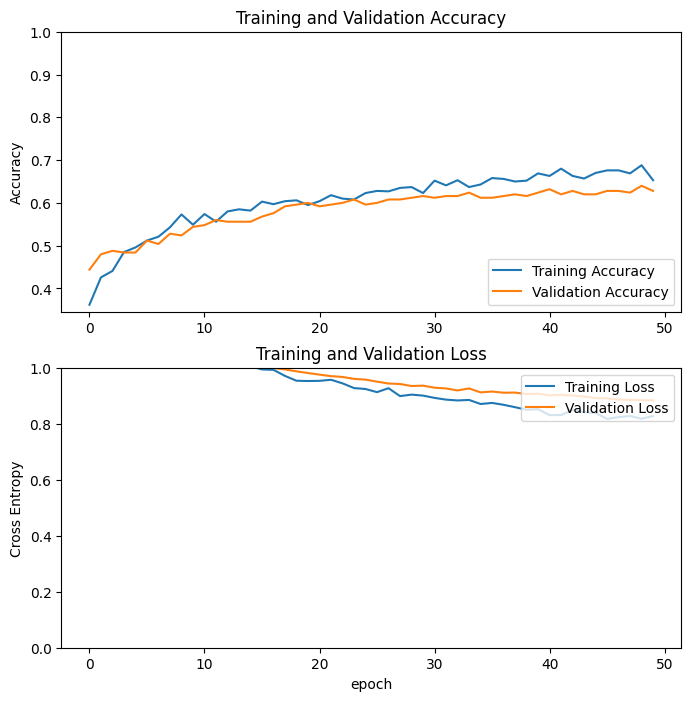

In [289]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 895ms/step


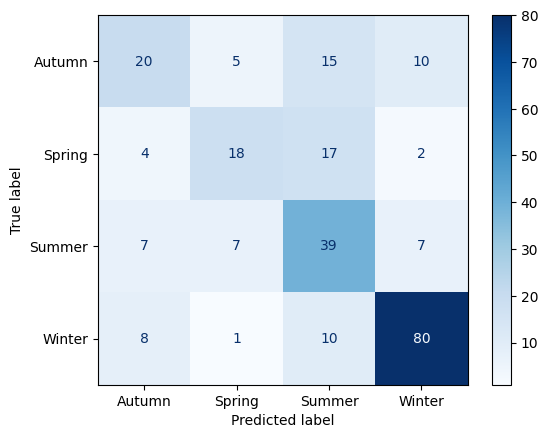

In [290]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

for images, labels in validation_dataset:
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)

    true_classes = labels.numpy()
    y_true.extend(true_classes)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)

class_names = validation_dataset.class_names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Save Model

In [291]:
model.save('/content/drive/MyDrive/Uwe/model-season-50-added.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [292]:
os.getcwd()

'/content'

In [5]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Uwe/model-season-50.h5')

TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

In [ ]:
from tensorflow.keras.preprocessing import image
img_path = '/content/drive/MyDrive/Capstone/SeasonSegmented/Autumn/Autumn1.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Capstone/SeasonSegmented/Autumn/Autumn1.jpg'

In [ ]:
predictions = model.predict(img_array)


In [ ]:
print(predictions)

In [ ]:
max_confidence_index = np.argmax(predictions[0])

categories = ['Autumn', 'Spring', 'Summer', 'Winter']

predicted_category = categories[max_confidence_index]
confidence_score = predictions[0][max_confidence_index]

print(f"Predicted Category: {predicted_category} with Confidence Score: {confidence_score:.2f}")

# Convert to json

In [295]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 603.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
  

In [2]:
import tensorflow as tf

tf.saved_model.save(model, "/content/drive/MyDrive/Uwe/Model_Season_50_h5")

NameError: name 'model' is not defined

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='MobilenetV1/Predictions/Reshape_1' \
    --saved_model_tags=serve \
    /content/drive/MyDrive/Uwe/Model_Season_50_h5 \
    /content/drive/MyDrive/Uwe/Model_Season_50_json